In [14]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

In [15]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA


In [17]:
import numpy as np
import pandas as pd

# Configuração inicial
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by=['Ticker', 'Date'], inplace=True)

# Cálculo da mudança no preço
price_data['change_in_price'] = price_data['Close'].diff()
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)
price_data['change_in_price'] = np.where(mask, np.nan, price_data['change_in_price'])
price_data[price_data.isna().any(axis = 1)]


# Função de suavização exponencial
def exponential_smoothing(data, alpha):
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    return np.sign(data.shift(-d) - data)

# Função para calcular o target e ajustar valores zero para -1
def calculate_target_verify(data, d):
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1
    return target

# Função OBV ajustada
def obv(group, smoothed_col):
    Volume = group['Volume']
    change = group[smoothed_col].diff()
    prev_obv = 0
    obv_values = []
    for i, j in zip(change, Volume):
        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv
        prev_obv = current_obv
        obv_values.append(current_obv)
    return pd.Series(obv_values, index=group.index)

# Lista de alphas e parâmetros gerais
alpha_list = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
n = 14
d = 10
t = 15
e = 14

# Loop para cálculos por alpha
for alpha in alpha_list:
    smoothed_col = f'Smoothed_Close_{alpha:.2f}'
    target_col = f'Prediction_{alpha:.2f}'
    obv_col = f'OBV_{alpha:.2f}'
    price_rate_col = f'Price_Rate_Of_Change_{alpha:.2f}'
    macd_col = f'MACD_{alpha:.2f}'
    macd_ema_col = f'MACD_EMA_{alpha:.2f}'
    low_col = f'low_{t}_{alpha:.2f}'
    high_col = f'high_{t}_{alpha:.2f}'
    k_percent_col = f'k_percent_{alpha:.2f}'
    r_percent_col = f'r_percent_{alpha:.2f}'
    
    # Suavização exponencial
    price_data[smoothed_col] = price_data.groupby('Ticker')['Close'].transform(
        lambda x: exponential_smoothing(x.values, alpha)
    )
    
    # Target
    price_data[target_col] = price_data.groupby('Ticker')[smoothed_col].transform(
        lambda x: calculate_target(x, d)
    )
    
    # OBV
    obv_groups = price_data.groupby('Ticker').apply(lambda group: obv(group, smoothed_col))
    price_data[obv_col] = obv_groups.reset_index(level=0, drop=True)
    
    # Price Rate of Change
    price_data[price_rate_col] = price_data.groupby('Ticker')[smoothed_col].transform(
        lambda x: x.pct_change(periods=e)
    )
    
    
    # %R
    low_t = price_data[['Ticker', 'Low']].copy()
    high_t = price_data[['Ticker', 'High']].copy()
    low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window=t).min())
    high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window=t).max())
    r_percent = ((high_t - price_data[smoothed_col]) / (high_t - low_t)) * (-100)
    price_data[low_col] = low_t
    price_data[high_col] = high_t
    price_data[r_percent_col] = r_percent

    # %K    
    k_percent = ((price_data[smoothed_col] - low_t) / (high_t - low_t)) * 100
    price_data[k_percent_col] = k_percent
    
    # MACD
    ema_26 = price_data.groupby('Ticker')[smoothed_col].transform(lambda x: x.ewm(span=26).mean())
    ema_12 = price_data.groupby('Ticker')[smoothed_col].transform(lambda x: x.ewm(span=12).mean())
    macd = ema_12 - ema_26
    ema_9_macd = macd.ewm(span=9).mean()
    price_data[macd_col] = macd
    price_data[macd_ema_col] = ema_9_macd

    # Calculando o Price Rate of Change (ROC) usando a coluna suavizada correspondente
    price_data[price_rate_col] = price_data.groupby('Ticker')[smoothed_col].transform(lambda x: x.pct_change(periods=e))


# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)

# Calculando o target para d = 10 dias
d = 10
price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)

# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-d)

# Drop linhas com valores ausentes
price_data = price_data.dropna()

# Visualização final
price_data.tail()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close_0.10,Prediction_0.10,OBV_0.10,Price_Rate_Of_Change_0.10,low_15_0.10,high_15_0.10,r_percent_0.10,k_percent_0.10,MACD_0.10,MACD_EMA_0.10,Smoothed_Close_0.20,Prediction_0.20,OBV_0.20,Price_Rate_Of_Change_0.20,low_15_0.20,high_15_0.20,r_percent_0.20,k_percent_0.20,MACD_0.20,MACD_EMA_0.20,Smoothed_Close_0.30,Prediction_0.30,OBV_0.30,Price_Rate_Of_Change_0.30,low_15_0.30,high_15_0.30,r_percent_0.30,k_percent_0.30,MACD_0.30,MACD_EMA_0.30,Smoothed_Close_0.40,Prediction_0.40,OBV_0.40,Price_Rate_Of_Change_0.40,low_15_0.40,high_15_0.40,r_percent_0.40,k_percent_0.40,MACD_0.40,MACD_EMA_0.40,Smoothed_Close_0.50,Prediction_0.50,OBV_0.50,Price_Rate_Of_Change_0.50,low_15_0.50,high_15_0.50,r_percent_0.50,k_percent_0.50,MACD_0.50,MACD_EMA_0.50,Smoothed_Close_0.60,Prediction_0.60,OBV_0.60,Price_Rate_Of_Change_0.60,low_15_0.60,high_15_0.60,r_percent_0.60,k_percent_0.60,MACD_0.60,MACD_EMA_0.60,Smoothed_Close_0.70,Prediction_0.70,OBV_0.70,Price_Rate_Of_Change_0.70,low_15_0.70,high_15_0.70,r_percent_0.70,k_percent_0.70,MACD_0.70,MACD_EMA_0.70,Smoothed_Close_0.80,Prediction_0.80,OBV_0.80,Price_Rate_Of_Change_0.80,low_15_0.80,high_15_0.80,r_percent_0.80,k_percent_0.80,MACD_0.80,MACD_EMA_0.80,Smoothed_Close_0.90,Prediction_0.90,OBV_0.90,Price_Rate_Of_Change_0.90,low_15_0.90,high_15_0.90,r_percent_0.90,k_percent_0.90,MACD_0.90,MACD_EMA_0.90,down_days,up_days,RSI,Smoothed_Close_1,Verify,Close_10
11759,2024-12-18,55.770000,55.869999,54.759998,54.810001,54.810001,34658200,VALE3.SA,-1.299999,57.497334,-1.0,2710792648,-0.022911,54.759998,60.189999,-49.588668,50.411332,-0.626553,-0.565381,56.652512,-1.0,2314243370,-0.023719,54.759998,60.189999,-65.147077,34.852923,-0.703017,-0.645170,56.142953,-1.0,441070762,-0.028889,54.759998,60.189999,-74.531231,25.468769,-0.743239,-0.646707,55.777082,-1.0,790180166,-0.034308,54.759998,60.189999,-81.269172,18.730828,-0.788698,-0.651609,55.518702,-1.0,725526526,-0.038303,54.759998,60.189999,-86.027564,13.972436,-0.829842,-0.660743,55.332883,-1.0,335695238,-0.041019,54.759998,60.189999,-89.449647,10.550353,-0.863374,-0.670946,55.188184,-1.0,527625942,-0.042963,54.759998,60.189999,-92.114445,7.885555,-0.889788,-0.680605,55.061136,-1.0,-1074414442,-0.044538,54.759998,60.189999,-94.454189,5.545811,-0.910794,-0.689166,54.937339,-1.0,-908703138,-0.045957,54.759998,60.189999,-96.734067,3.265933,-0.928172,-0.696584,1.299999,0.000000,29.625170,54.810001,-1.0,52.049999
11760,2024-12-19,55.020000,55.169998,53.599998,53.770000,53.770000,29529900,VALE3.SA,-1.040001,57.124600,-1.0,2681262748,-0.029137,53.599998,60.189999,-46.515904,53.484096,-0.676722,-0.587649,56.076010,-1.0,2284713470,-0.036149,53.599998,60.189999,-62.427750,37.572250,-0.788063,-0.673749,55.431067,-1.0,411540862,-0.045989,53.599998,60.189999,-72.214440,27.785560,-0.858741,-0.689114,54.974250,-1.0,760650266,-0.054893,53.599998,60.189999,-79.146417,20.853583,-0.924517,-0.706191,54.644351,-1.0,695996626,-0.061980,53.599998,60.189999,-84.152465,15.847535,-0.979044,-0.724403,54.395153,-1.0,306165338,-0.067744,53.599998,60.189999,-87.933918,12.066082,-1.022297,-0.741216,54.195456,-1.0,498096042,-0.072721,53.599998,60.189999,-90.964233,9.035767,-1.056708,-0.755826,54.028228,-1.0,-1103944342,-0.077222,53.599998,60.189999,-93.501835,6.498165,-1.084755,-0.768284,53.886734,-1.0,-938233038,-0.081378,53.599998,60.189999,-95.648926,4.351074,-1.108238,-0.778915,1.040001,0.000000,25.057364,53.770000,-1.0,51.549999
11761,2024-12-20,53.419998,54.619999,53.330002,54.619999,54.619999,64919500,VALE3.SA,0.849998,56.874140,-1.0,2616343248,-0.033526,53.330002,60.189999,-48.336150,51.663850,-0.728296,-0.615779,55.784808,-1.0,2219793970,-0.043590,53.330002,60.189999,-64.215642,35.784358,-0.868943,-0.712788,55.187747,-1.0,346621362,-0.054166,53.330002,60.189999,-72.919161,27.080839,-0.958858,-0.743063,54.832549,-1.0,695730766,-0.062184,53.330002,60.189999,-78.096965,21.903035,-1.031696,-0.771292,54.632175,-1.0,631077

#### Se quiser rodar para um Ticker.

In [18]:
price_data = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close_0.10,Prediction_0.10,OBV_0.10,Price_Rate_Of_Change_0.10,low_15_0.10,high_15_0.10,r_percent_0.10,k_percent_0.10,MACD_0.10,MACD_EMA_0.10,Smoothed_Close_0.20,Prediction_0.20,OBV_0.20,Price_Rate_Of_Change_0.20,low_15_0.20,high_15_0.20,r_percent_0.20,k_percent_0.20,MACD_0.20,MACD_EMA_0.20,Smoothed_Close_0.30,Prediction_0.30,OBV_0.30,Price_Rate_Of_Change_0.30,low_15_0.30,high_15_0.30,r_percent_0.30,k_percent_0.30,MACD_0.30,MACD_EMA_0.30,Smoothed_Close_0.40,Prediction_0.40,OBV_0.40,Price_Rate_Of_Change_0.40,low_15_0.40,high_15_0.40,r_percent_0.40,k_percent_0.40,MACD_0.40,MACD_EMA_0.40,Smoothed_Close_0.50,Prediction_0.50,OBV_0.50,Price_Rate_Of_Change_0.50,low_15_0.50,high_15_0.50,r_percent_0.50,k_percent_0.50,MACD_0.50,MACD_EMA_0.50,Smoothed_Close_0.60,Prediction_0.60,OBV_0.60,Price_Rate_Of_Change_0.60,low_15_0.60,high_15_0.60,r_percent_0.60,k_percent_0.60,MACD_0.60,MACD_EMA_0.60,Smoothed_Close_0.70,Prediction_0.70,OBV_0.70,Price_Rate_Of_Change_0.70,low_15_0.70,high_15_0.70,r_percent_0.70,k_percent_0.70,MACD_0.70,MACD_EMA_0.70,Smoothed_Close_0.80,Prediction_0.80,OBV_0.80,Price_Rate_Of_Change_0.80,low_15_0.80,high_15_0.80,r_percent_0.80,k_percent_0.80,MACD_0.80,MACD_EMA_0.80,Smoothed_Close_0.90,Prediction_0.90,OBV_0.90,Price_Rate_Of_Change_0.90,low_15_0.90,high_15_0.90,r_percent_0.90,k_percent_0.90,MACD_0.90,MACD_EMA_0.90,down_days,up_days,RSI,Smoothed_Close_1,Verify,Close_10
5726,2024-12-18,13.07,13.08,12.75,12.76,12.515584,40864200,ABEV3.SA,-0.340000,13.230223,-1.0,-2647212884,0.050797,12.25,14.53,-57.007752,42.992248,0.147413,0.112509,13.226949,-1.0,-2269855222,0.055899,12.25,14.53,-57.151342,42.848658,0.191043,0.181782,13.104115,-1.0,-2445072948,0.047480,12.25,14.53,-62.538817,37.461183,0.179758,0.206842,12.996276,-1.0,-1743888488,0.039948,12.25,14.53,-67.268611,32.731389,0.156263,0.211912,12.924687,-1.0,-1490189470,0.035439,12.25,14.53,-70.408449,29.591551,0.134741,0.209811,12.879257,-1.0,-1177840068,0.033148,12.25,14.53,-72.401003,27.598997,0.117994,0.205653,12.847274,-1.0,-1511608966,0.031994,12.25,14.53,-73.803773,26.196227,0.105477,0.201311,12.819806,-1.0,-1421539626,0.031196,12.25,14.53,-75.008522,24.991478,0.096013,0.197379,12.791650,-1.0,-1356589976,0.030293,12.25,14.53,-76.243431,23.756569,0.088568,0.193971,0.340000,0.00,35.748723,12.76,-1.0,11.54
5727,2024-12-19,12.76,12.91,12.64,12.78,12.535200,38104000,ABEV3.SA,0.020000,13.185201,-1.0,-2685316884,0.046064,12.25,14.53,-58.982416,41.017584,0.136481,0.117303,13.137559,-1.0,-2307959222,0.045371,12.25,14.53,-61.071953,38.928047,0.160453,0.177516,13.006880,-1.0,-2483176948,0.034254,12.25,14.53,-66.803490,33.196510,0.137258,0.192926,12.909765,-1.0,-1781992488,0.025380,12.25,14.53,-71.062925,28.937075,0.108994,0.191328,12.852344,-1.0,-1528293470,0.019529,12.25,14.53,-73.581422,26.418578,0.086416,0.185132,12.819703,-1.0,-1215944068,0.015469,12.25,14.53,-75.013038,24.986962,0.070052,0.178533,12.800182,-1.0,-1549712966,0.012217,12.25,14.53,-75.869208,24.130792,0.058307,0.172710,12.787961,-1.0,-1459643626,0.009279,12.25,14.53,-76.405220,23.594780,0.049676,0.167838,12.781165,-1.0,-1394693976,0.006506,12.25,14.53,-76.703299,23.296701,0.043139,0.163805,0.000000,0.02,36.474660,12.78,-1.0,11.42
5728,2024-12-20,12.08,12.30,12.01,12.23,12.230000,86074600,ABEV3.SA,-0.550000,13.089681,-1.0,-2771391484,0.033195,12.01,14.53,-57.155529,42.844471,0.118741,0.117591,12.956047,-1.0,-2394033822,0.019848,12.01,14.53,-62.458438,37.541562,0.120178,0.166048,12.773816,-1.0,-2569251548,-0.000348,12.01,14.53,-69.689841,30.310159,0.083804,0.171101,12.637859,-1.0,-1868067088,-0.016825,12.01,14.53,-75.084966,24.915034,0.049028,0.162868,12.541172,-1.0,-1614368070,-0.029928,12.01,14.53,-78.921770,21.078230,0.022747,0.152655,12.465881,-1.0,-1302018668,-0.041069,12.01,14.53,-81.909498,18.090502,0.003468,0.143520,12.401054,-1.0,-1635787566,-0.051088,12.01,14.53,-84.481979,15.518021,-0.011153,0.135938,12.341592,-1.0,-1545718226,-0.060

In [ ]:
price_data = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]
price_data.tail()

In [ ]:
price_data = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]
price_data.tail()

In [ ]:
price_data = price_data[price_data['Ticker'].isin(['PETR4.SA'])]
price_data.tail()

In [ ]:
price_data = price_data[price_data['Ticker'].isin(['VALE3.SA'])]
price_data.tail()

#### Se quiser normal só pular etapa anterior.

In [19]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Para cada alpha, criar as variáveis X_Cols e Y_Cols e treinar o modelo
for alpha in alpha_list:
    # Definindo as colunas de X e Y dinamicamente
    X_Cols = price_data[['RSI',
                         f'k_percent_{alpha:.2f}',
                         f'r_percent_{alpha:.2f}',
                         f'Price_Rate_Of_Change_{alpha:.2f}',
                         f'MACD_{alpha:.2f}',
                         f'MACD_EMA_{alpha:.2f}',
                         f'OBV_{alpha:.2f}']]
    
    Y_Cols = price_data[f'Prediction_{alpha:.2f}']

    # Dividir os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

    # Criar o classificador Random Forest
    rand_frst_clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

    # Ajustar o modelo
    rand_frst_clf.fit(X_train, y_train)

    # Fazer previsões
    y_pred = rand_frst_clf.predict(X_test)

    # Imprimir a acurácia
    accuracy = accuracy_score(y_test, y_pred, normalize=True) * 100.0
    print(f'Alpha: {alpha}')
    print(f'Correct Prediction (%): {accuracy:.5f}')
    print('---')


Alpha: 0.1
Correct Prediction (%): 85.62412
---
Alpha: 0.2
Correct Prediction (%): 78.19074
---
Alpha: 0.3
Correct Prediction (%): 76.36746
---
Alpha: 0.4
Correct Prediction (%): 73.77279
---
Alpha: 0.5
Correct Prediction (%): 74.19355
---
Alpha: 0.6
Correct Prediction (%): 75.03506
---
Alpha: 0.7
Correct Prediction (%): 74.68443
---
Alpha: 0.8
Correct Prediction (%): 72.23001
---
Alpha: 0.9
Correct Prediction (%): 72.93128
---


#### Últimos 30 dias

In [26]:
import warnings
from datetime import timedelta

# Desativa todos os warnings
warnings.filterwarnings("ignore")

# Filtrar últimos 30 dias
last_30_days = price_data[price_data['Date'] >= price_data['Date'].max() - timedelta(days=30)]

# Para cada alpha, selecionar as colunas de X, gerar previsões e comparar com a coluna 'Verify'
for alpha in alpha_list:
    # Selecionar as colunas de X como um array NumPy
    X_Cols = last_30_days[['RSI',
                           f'k_percent_{alpha:.2f}',
                           f'r_percent_{alpha:.2f}',
                           f'Price_Rate_Of_Change_{alpha:.2f}',
                           f'MACD_{alpha:.2f}',
                           f'MACD_EMA_{alpha:.2f}',
                           f'OBV_{alpha:.2f}']].values

    # Gerar previsões e atualizar a coluna 'Prediction_{alpha}' para os últimos 30 dias
    last_30_days[f'Prediction_{alpha:.2f}'] = rand_frst_clf.predict(X_Cols)

    # Comparar as previsões de 'Prediction_{alpha}' com 'Verify' e calcular a precisão
    last_30_days['Match'] = (last_30_days[f'Prediction_{alpha:.2f}'] == last_30_days['Verify']).astype(int)  # 1 para igual, 0 para diferente
    accuracy = last_30_days['Match'].mean()  # Proporção de acertos (iguais / total)

    # Imprimir a precisão para cada alpha
    print(f'\nPrecisão para Alpha: {alpha}')
    print(f'Precisão do modelo nos últimos 30 dias: {accuracy:.2%}')



Precisão para Alpha: 0.1
Precisão do modelo nos últimos 30 dias: 68.42%

Precisão para Alpha: 0.2
Precisão do modelo nos últimos 30 dias: 89.47%

Precisão para Alpha: 0.3
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.4
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.5
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.6
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.7
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.8
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.9
Precisão do modelo nos últimos 30 dias: 100.00%


#### Time Series com Verify e plotagem

Alpha: 0.1
Fold 1:
 - Correct Prediction (y_test): 63.26%
 - Correct Prediction (Verify): 49.05%
Fold 2:
 - Correct Prediction (y_test): 66.95%
 - Correct Prediction (Verify): 49.58%
Fold 3:
 - Correct Prediction (y_test): 64.84%
 - Correct Prediction (Verify): 44.63%
Fold 4:
 - Correct Prediction (y_test): 64.42%
 - Correct Prediction (Verify): 58.84%
Fold 5:
 - Correct Prediction (y_test): 71.47%
 - Correct Prediction (Verify): 51.47%
Média de acurácia (y_test) para alpha 0.1: 66.19%
Média de acurácia (Verify) para alpha 0.1: 50.72%
---
Alpha: 0.2
Fold 1:
 - Correct Prediction (y_test): 51.05%
 - Correct Prediction (Verify): 48.11%
Fold 2:
 - Correct Prediction (y_test): 60.63%
 - Correct Prediction (Verify): 55.26%
Fold 3:
 - Correct Prediction (y_test): 56.63%
 - Correct Prediction (Verify): 43.79%
Fold 4:
 - Correct Prediction (y_test): 59.16%
 - Correct Prediction (Verify): 54.53%
Fold 5:
 - Correct Prediction (y_test): 56.32%
 - Correct Prediction (Verify): 48.74%
Média de acurá

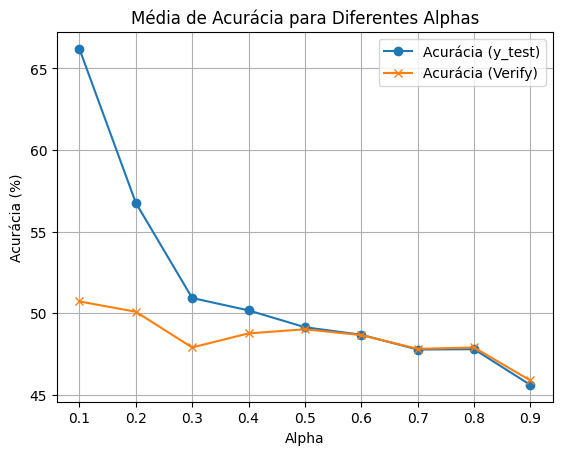

In [20]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por alpha
mean_accuracy_by_alpha = []

# Loop para cada alpha e realização de validação cruzada em série temporal
for alpha in alpha_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}',
                    f'r_percent_{alpha:.2f}',
                    f'Price_Rate_Of_Change_{alpha:.2f}',
                    f'MACD_{alpha:.2f}',
                    f'MACD_EMA_{alpha:.2f}',
                    f'OBV_{alpha:.2f}']]
    y = price_data[f'Prediction_{alpha:.2f}']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse alpha
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []

    print(f'Alpha: {alpha}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por alpha
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_alpha.append((alpha, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para alpha {alpha}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para alpha {alpha}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for alpha, acc_ytest, acc_verify in mean_accuracy_by_alpha:
    print(f'Alpha: {alpha:.2f} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por alpha
import matplotlib.pyplot as plt

alphas, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_alpha)

plt.plot(alphas, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(alphas, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Alphas")
plt.xlabel('Alpha')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()


#### Time Series com verify

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Loop para cada alpha e realização de validação cruzada em série temporal
for alpha in alpha_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}',
                    f'r_percent_{alpha:.2f}',
                    f'Price_Rate_Of_Change_{alpha:.2f}',
                    f'MACD_{alpha:.2f}',
                    f'MACD_EMA_{alpha:.2f}',
                    f'OBV_{alpha:.2f}']]
    y = price_data[f'Prediction_{alpha:.2f}']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    print(f'Alpha: {alpha}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar os resultados das acurácias
        all_accuracy_scores_ytest.append(accuracy_ytest)
        all_accuracy_scores_verify.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    print('---')

# Resultados gerais
print("Resumo geral:")
print(f'Média de acurácia (y_test): {np.mean(all_accuracy_scores_ytest):.2f}%')
print(f'Média de acurácia (Verify): {np.mean(all_accuracy_scores_verify):.2f}%')


Alpha: 0.1
Fold 1:
 - Correct Prediction (y_test): 60.90%
 - Correct Prediction (Verify): 49.16%
Fold 2:
 - Correct Prediction (y_test): 67.82%
 - Correct Prediction (Verify): 48.74%
Fold 3:
 - Correct Prediction (y_test): 61.64%
 - Correct Prediction (Verify): 40.67%
Fold 4:
 - Correct Prediction (y_test): 64.05%
 - Correct Prediction (Verify): 57.44%
Fold 5:
 - Correct Prediction (y_test): 70.65%
 - Correct Prediction (Verify): 51.57%
---
Alpha: 0.2
Fold 1:
 - Correct Prediction (y_test): 53.25%
 - Correct Prediction (Verify): 50.21%
Fold 2:
 - Correct Prediction (y_test): 59.22%
 - Correct Prediction (Verify): 55.24%
Fold 3:
 - Correct Prediction (y_test): 58.07%
 - Correct Prediction (Verify): 45.70%
Fold 4:
 - Correct Prediction (y_test): 58.60%
 - Correct Prediction (Verify): 55.45%
Fold 5:
 - Correct Prediction (y_test): 55.45%
 - Correct Prediction (Verify): 48.32%
---
Alpha: 0.3
Fold 1:
 - Correct Prediction (y_test): 49.37%
 - Correct Prediction (Verify): 48.22%
Fold 2:
 - Co

#### Time Series sem Verify

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Loop para cada alpha e realização de validação cruzada em série temporal
for alpha in alpha_list:
    # Definir as features (X) e o target (Y) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}',
                    f'r_percent_{alpha:.2f}',
                    f'Price_Rate_Of_Change_{alpha:.2f}',
                    f'MACD_{alpha:.2f}',
                    f'MACD_EMA_{alpha:.2f}',
                    f'OBV_{alpha:.2f}']]
    y = price_data[f'Prediction_{alpha:.2f}']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y], axis=1).dropna()
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    print(f'Alpha: {alpha}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0,oob_score = True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Calcular e imprimir a acurácia para cada divisão
        accuracy = accuracy_score(y_test, y_pred) * 100.0
        print(f'Fold {fold}: Correct Prediction (%): {accuracy:.2f}')
        fold += 1

    print('---')


#### Salvando

In [ ]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

In [ ]:
price_data.to_excel('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/test_day.xlsx', index=False)